## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [1]:
# !pip install ipyleaflet
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [3]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [4]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [59]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBSBBSSB'
#meas='SNWD'
meas='PRCP'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
2175
+-------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-----------+---------+------+--------------------+------+
|            coeff_1|            coeff_2|            coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|             res_2|             res_3|          res_mean|    station|total_var|undefs|              vector|  year|
+-------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-----------+---------+------+--------------------+------+
|-484.60267828058574|-209.80426922275274| -373.6314636526174|    938.8|SBSBBSSB| 46.4922|-115.8006|       PRCP|0.8431745480822247|0.8143982914393372|0.7218029212238536|0.8236406985543602|USC

In [60]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

### to get min/max latitude,longitude
Query="SELECT min(latitude), max(latitude), min(longitude), max(longitude) FROM weather"
print(Query)
df2 = sqlContext.sql(Query)
df2.show()

SELECT station, latitude,longitude,elevation,coeff_1 FROM weather
+-----------+--------+---------+---------+-------------------+
|    station|latitude|longitude|elevation|            coeff_1|
+-----------+--------+---------+---------+-------------------+
|USC00107046| 46.4922|-115.8006|    938.8|-484.60267828058574|
|USC00102845| 46.5022|-116.3217|    303.3| -246.6283119242687|
|USC00104150| 46.6311|-115.8086|    975.4|  -474.564149497105|
|USS0015B14S| 47.0833|-115.9667|   1862.3|-1023.7738030293683|
+-----------+--------+---------+---------+-------------------+
only showing top 4 rows

SELECT min(latitude), max(latitude), min(longitude), max(longitude) FROM weather
+-------------+-------------+--------------+--------------+
|min(latitude)|max(latitude)|min(longitude)|max(longitude)|
+-------------+-------------+--------------+--------------+
|      46.2325|      47.3111|     -119.3192|     -115.8006|
+-------------+-------------+--------------+--------------+



In [61]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)

,station,latitude,longitude,elevation,count(station),avg(coeff_1)
20,US1IDBW0003,47.2750,-116.5770,766.9,3,-234.900118
41,US1IDCW0004,46.5059,-116.3203,311.5,3,-146.678459


In [62]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#800000'

## Map

In [63]:
min_lat,max_lat,min_long,max_long = box = (46.2325, 47.3, -119.3192, -115.8006)


In [16]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

In [53]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 8

_map = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
_map += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []

# [ 9 33 38  7 42 13 11 40]
# USC00106421 # USC00456784 # USC00457223
# USC00105236 # USW00024110 # USC00107301
# USC00106681 # USC00457956
correl_stations = ['USC00106421', 'USC00456784', 'USC00457223', 'USC00105236', 'USW00024110', 'USC00107301', 'USC00106681', 'USC00457956']
# correl_stations = ['USC00106421']

for index,row in pdf.iterrows():
     if row['station'] in correl_stations:
        _lat = row['latitude']
        _long = row['longitude']
        _count=row['count(station)']
        _coeff=200
        print "station=", row['station'], " lat=", _lat, " long=", _long, " elevation=", row['elevation']
        c = Circle(location=(_lat, _long), radius=int(300*np.sqrt(100+0.0)), weight=2,
                color='#F00', opactiy=0.8, fill_opactiy=0.6, fill_color=get_color(_coeff))
        circles.append(c)
        _map.add_layer(c)   
_map  

station= USC00105236  lat= 46.4167  long= -117.0167  elevation= 225.9
station= USC00106421  lat= 46.2333  long= -116.2333  elevation= 939.1
station= USC00106681  lat= 46.4833  long= -116.2667  elevation= 402.3
station= USC00107301  lat= 46.9603  long= -116.855  elevation= 841.2
station= USC00456784  lat= 46.7333  long= -117.1667  elevation= 787.0
station= USC00457223  lat= 47.1333  long= -119.05  elevation= 438.9
station= USC00457956  lat= 47.3  long= -117.9833  elevation= 600.5
station= USW00024110  lat= 47.2078  long= -119.3192  elevation= 364.5


In [46]:
# Map of highly correlated stations for SNWD
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 8

_map2 = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
_map2 += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []

for index,row in pdf.iterrows():
    # USC00109846 # USC00102892 # USC00100528 # USC00104150 # USC00107046
    if row['station'] == 'USC00109846' or row['station'] == 'USC00102892' or row['station'] == 'USC00100528' or row['station'] == 'USC00104150' or row['station'] == 'USC00107046': 
        _lat = row['latitude']
        _long = row['longitude']
        _count=row['count(station)']
        _coeff=200
        print "station=", row['station'], " lat=", _lat, " long=", _long, " elevation=", row['elevation']
        c = Circle(location=(_lat, _long), radius=int(300*np.sqrt(100+0.0)), weight=2,
                color='#F00', opactiy=0.8, fill_opactiy=0.6, fill_color=get_color(_coeff))
        circles.append(c)
        _map2.add_layer(c)
         
_map2  

station= USC00100528  lat= 47.2533  long= -115.9203  elevation= 729.7
station= USC00102892  lat= 46.7744  long= -116.1761  elevation= 889.4
station= USC00104150  lat= 46.6311  long= -115.8086  elevation= 975.4
station= USC00107046  lat= 46.4922  long= -115.8006  elevation= 938.8
station= USC00109846  lat= 46.2381  long= -116.6233  elevation= 1210.7


In [67]:
#[ 3 15  6  5  4  0 14  8]

# map for correlated prcp
_map3 = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)
correl_stations=['US1IDLT0001', 'US1WAWM0005', 'US1IDLT0007', 'US1IDLT0006', 'US1IDLT0004', 'US1IDBW0003','US1WAWM0004','US1IDNP0001']


r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
_map3 += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
hey=0
for index,row in pdf.iterrows():
    if row['station'] in correl_stations:
        
        _lat = row['latitude']
        _long = row['longitude']
        _count=row['count(station)']
        _coeff=200
        print "station=", row['station'], " lat=", _lat, " long=", _long, " elevation=", row['elevation']
        c = Circle(location=(_lat, _long), radius=int(300*np.sqrt(100+0.0)), weight=2,
                color='#F00', opactiy=0.8, fill_opactiy=0.6, fill_color=get_color(_coeff))
        circles.append(c)
        _map3.add_layer(c)
    
_map3


station= US1IDBW0003  lat= 47.275  long= -116.577  elevation= 766.9
station= US1IDLT0001  lat= 46.7544  long= -117.0005  elevation= 823.0
station= US1IDLT0004  lat= 46.7762  long= -116.857  elevation= 949.8
station= US1IDLT0006  lat= 46.929  long= -116.8874  elevation= 805.0
station= US1IDLT0007  lat= 46.7288  long= -116.9729  elevation= 802.8
station= US1IDNP0001  lat= 46.5203  long= -116.6743  elevation= 287.4
station= US1WAWM0004  lat= 46.7276  long= -117.1798  elevation= 737.0
station= US1WAWM0005  lat= 46.8658  long= -117.0899  elevation= 772.7


### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

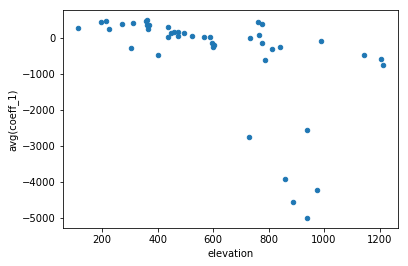

In [17]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');

In [18]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()

['spark big  data analysis', 'spring', 'spark  basics']